<a href="https://colab.research.google.com/github/HugoSave/adversarial-image-attacks/blob/main/AdversarialAttacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision timm detectors matplotlib numpy einops pandas plotnine


import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as pn
from dataclasses import dataclass
from typing import List
import einops


import detectors # includes models needed for timm
import timm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.8/616.8 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
@dataclass
class ModelConfig:
    name: str
    model: nn.Module

    def __repr__(self):
        return f"ModelConfig(name='{self.name}', model={self.model})"

In [3]:
# Create models with pretrained weights from timm
# https://huggingface.co/edadaltocg/resnet18_cifar10
resnet18_cifar10 = timm.create_model("resnet18_cifar10", pretrained=True).to(device)
resnet18_cifar10.eval() # we won't be training the models ever in the script
# https://huggingface.co/edadaltocg/vgg16_bn_cifar10
vgg16_bn_cifar10 = timm.create_model("vgg16_bn_cifar10", pretrained=True).to(device)
vgg16_bn_cifar10.eval()

# Store in list of model configs
models_list = [
    ModelConfig(name="resnet18_cifar10", model=resnet18_cifar10),
    ModelConfig(name="vgg16_bn_cifar10", model=vgg16_bn_cifar10)
]



Downloading: "https://huggingface.co/edadaltocg/resnet18_cifar10/resolve/main/pytorch_model.bin" to /root/.cache/torch/hub/checkpoints/resnet18_cifar10.pth
100%|██████████| 42.7M/42.7M [00:01<00:00, 25.5MB/s]
Downloading: "https://huggingface.co/edadaltocg/vgg16_bn_cifar10/resolve/main/pytorch_model.bin" to /root/.cache/torch/hub/checkpoints/vgg16_bn_cifar10.pth
100%|██████████| 56.2M/56.2M [00:02<00:00, 24.3MB/s]


With the models loaded into a list, we can now load the test set containing images that we later will be performing the adversarial attacks on. For test set we are using cifar10 which our models have already been trained on. We do this to have comparatively similar accuracies between the two models. This will make the adversarial performance losses more comparable between models.

In [4]:
CIFAR10_MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
CIFAR10_STD = torch.tensor([0.2470, 0.2435, 0.2616])

def get_normalized_cifar10_dataset(root="./data", train=False, device=device):
    """
    Returns a DataLoader for CIFAR-10 dataset with standard transforms.

    Args:
        root (str): Root directory where the CIFAR-10 dataset will be stored or is already stored.

        train (bool): Whether to load the training set or test set.
    Returns:
        DataLoader: timm dataset of cifar10 dataset. Elements are tuples of (image, label).
        image is a torch.Tensor of shape (3, 32, 32) and label is an int.
    """

    # we normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    ])

    return datasets.CIFAR10(root=root, train=train, download=True, transform=transform)

def create_balanced_subset(dataset, num_samples_per_class=100, seed=42):
    """
    Creates a balanced subset from a classification dataset with a .targets attribute.

    Note that the dataset is not shuffled afterwards but sorted by label.

    Args:
        dataset: A pytorch dataset with a .targets attribute.
        num_samples_per_class (int): Number of samples to include per class.
        seed (int): Random seed for sampling from the classes.

    Returns:
        Subset: A torch.utils.data.Subset containing a balanced subset of the dataset.
    """
    np.random.seed(seed)

    targets = np.array(dataset.targets)
    num_classes = len(set(targets)) # set removes duplicated

    class_indices = {class_id: [] for class_id in range(num_classes)} # build dict to store which dataset indices each target label exists at

    # Collect indices for each class
    for idx, label in enumerate(targets):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        chosen = np.random.choice(indices, num_samples_per_class, replace=False)
        selected_indices.extend(chosen)

    return torch.utils.data.Subset(dataset, selected_indices)

def unnormalize_images(images, mean=CIFAR10_MEAN, std=CIFAR10_STD):
  images = images.cpu()
  mean = einops.rearrange(mean, 'c -> 1 c 1 1')
  std = einops.rearrange(std, 'c -> 1 c 1 1')
  images = images * std + mean
  return images

def unnormalize_image(image, mean=CIFAR10_MEAN, std=CIFAR10_STD):
  return unnormalize_images(image.unsqueeze(0), mean, std).squeeze(0)

def transpose_image(image):
  return einops.rearrange(image, 'c h w -> h w c')

def prepare_image_for_imshow(image):
  return transpose_image(unnormalize_image(image)).clip(0,1).numpy()

def show_cifar10_img(img, mean=CIFAR10_MEAN, std=CIFAR10_STD):
  img = prepare_image_for_imshow(img)
  #img = img.numpy().transpose((1, 2, 0))
  plt.imshow(img)
  plt.axis('off')
  plt.show()


In [5]:
def get_best_model_prediction(model, data, device=device):
  model = model.to(device)
  data = data.to(device)
  model.eval()
  with torch.no_grad():
    output = model(data)
    _, predicted = torch.max(output, 1)
  return predicted

def evaluate_accuracy(model, dataloader, device=None):
    """
    Evaluate accuracy of the model on the given dataloader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device or None): Device to run evaluation on (e.g., 'cuda' or 'cpu').
            If None, uses CUDA if available.

    Returns:
        float: Accuracy in percentage (0-100).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

def evaluate_accuracy_model_list(model_list, dataloader, device=None):
  for modelConfig in model_list:
    model = modelConfig.model
    name = modelConfig.name
    accuracy = evaluate_accuracy(model, dataloader, device=device)
    print(f"Accuracy of {name}: {accuracy:.2f}%")


Having set up the base evaluation code we will now generate the adversarial images

## FGSM Method

In [6]:
def FGSM_attack(model, images, labels, epsilons, device=device):
    """
    Parameters:
    model: trained model in eval mode
    imgs: Tensor of (B C H W)
    labels: Tensor of Corresponding labels of the images (B)
    epsilons: Tensor of epsilon values (C)

    Returns:
    detached tensor: fake_imgs (B C H W), noise_grads (B C H W)
    """
    model = model.to(device)
    epsilons = einops.rearrange(epsilons, 'c -> 1 c 1 1').to(device)
    input_images = images.clone().to(device)
    labels = labels.to(device)
    # We want the gradient with respect to the input image
    input_images.requires_grad = True
    # Determine prediction of the model
    logits = model(input_images)
    # Calculate loss with respect to the true label
    #loss = nn.CrossEntropyLoss()(logits, labels) # I thikn this is a bit wrong
    losses = nn.CrossEntropyLoss(reduction="none")(logits, labels)
    for loss in losses:
      # because every image processing in the forward pass is separated from each other,
      # we are not getting any double counting here
      loss.backward(retain_graph=True)
    # Update image to adversarial example as written above
    noise_grad = torch.sign(input_images.grad)
    fake_imgs = input_images + epsilons * noise_grad
    # Remove the tensor from the computational graph
    fake_imgs.detach_()
    return fake_imgs

While we are not using the batches for training, we are using them to control how many images we process in parallel.

In [7]:
def dataset_to_adversarial(model, dataset, attack_fun, batch_size, device=device):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    adv_imgs = []
    label_list = []

    for data, labels in dataloader:
        data = data.to(device)
        labels = labels.to(device)
        adv_batch = attack_fun(model, data, labels)
        adv_imgs.append(adv_batch.detach().cpu())
        label_list.append(labels.cpu())

    adv_imgs = torch.cat(adv_imgs, dim=0)
    labels = torch.cat(label_list, dim=0)

    return TensorDataset(adv_imgs, labels)


In [8]:
def i_fgsm_attack(model, images, labels, eps, alpha, clamp, iters=10, device=device):
    """
    Perform the Iterative FGSM (I-FGSM) adversarial attack.

    Args:
        model (torch.nn.Module): The model to attack.
        images (torch.Tensor): Input images (normalized). (B, C, W, H)
        labels (torch.Tensor): True labels.
        eps (tensor): Maximum perturbation per channel. shape: (C)
        alpha (float): Step size for each iteration per channel. shape: (C)
        iters (int): Number of iterations.
        clamp (tuple of tensors): Tuple of (tensor(min), tensor(max)) values to clamp image pixels after update.
            tensor(min) and tensor(max) have shape (C)

    Returns:
        torch.Tensor: Adversarially perturbed images. (B,C,W,H)
    """
    images  = images.clone().detach().to(device) # remove any potential history
    labels = labels.clone().detach().to(device)
    adv_images = images.clone().detach().to(device)
    # reshaping for broadcasting to work later
    alpha = einops.rearrange(alpha, 'c -> 1 c 1 1').to(device)
    eps = einops.rearrange(eps, 'c -> 1 c 1 1').to(device)
    clamp_min = einops.rearrange(clamp[0], 'c -> 1 c 1 1').to(device)
    clamp_max = einops.rearrange(clamp[1], 'c -> 1 c 1 1').to(device)

    for _ in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)


        losses = nn.CrossEntropyLoss(reduction="none")(outputs, labels) # we have one loss per image
        # we want individual backpropagations per image

        if adv_images.grad is not None: # is none on first iteration
          adv_images.grad.zero_()

        for loss in losses:
            loss.backward(retain_graph=True)

        # Gradient sign update
        grad_sign = adv_images.grad.sign()
        adv_images.data = adv_images.data + alpha * grad_sign

        # Project back to epsilon-ball and clamp to valid range
        delta = torch.clamp(adv_images.data - images, min=-eps, max=eps)
        adv_images.data = torch.clamp(images + delta, min=clamp_min, max=clamp_max)


    return adv_images


In [9]:
@dataclass
class AdversarialDatasetConfig:
    dataset_name: str                # e.g., "CIFAR-10"
    attack_name: str                 # e.g., "I-FGSM"
    model_name: str                  # e.g., "resnet18_cifar10"
    adversarial_dataset: Dataset    # torch.utils.data.Dataset (like TensorDataset)

    def __repr__(self):
        return (f"AdversarialDatasetConfig(dataset_name='{self.dataset_name}', "
                f"attack_name='{self.attack_name}', "
                f"model_name='{self.model_name}', "
                f"num_samples={len(self.adversarial_dataset)})")

In [10]:
def create_adversarial_datasets(model_configs, original_dataset, fgsm_attack_func, ifgsm_attack_func, batch_size):
    """
    Loops through a list of model configurations and applies FGSM and I-FGSM attacks
    to create a list of AdversarialDatasetConfigs.

    Args:
        model_configs (list[ModelConfig]): A list of ModelConfig objects.
        original_dataset (Dataset): The original dataset to attack.
        fgsm_attack_func (function): The function for the FGSM attack.
        ifgsm_attack_func (function): The function for the I-FGSM attack.
        batch_size (int): Batch size for generating adversarial examples.

    Returns:
        list[AdversarialDatasetConfig]: A list of generated AdversarialDatasetConfig objects.
    """
    adversarial_datasets = []

    for model_config in model_configs:
        model = model_config.model
        model_name = model_config.name

        # Generate FGSM adversarial dataset
        print(f"Generating FGSM adversarial dataset for model: {model_name}")
        fgsm_adv_dataset = dataset_to_adversarial(model, original_dataset, fgsm_attack_func, batch_size)
        adversarial_datasets.append(AdversarialDatasetConfig(
            dataset_name="CIFAR-10",
            attack_name="FGSM",
            model_name=model_name,
            adversarial_dataset=fgsm_adv_dataset
        ))

        # Generate I-FGSM adversarial dataset
        print(f"Generating I-FGSM adversarial dataset for model: {model_name}")
        ifgsm_adv_dataset = dataset_to_adversarial(model, original_dataset, ifgsm_attack_func, batch_size)
        adversarial_datasets.append(AdversarialDatasetConfig(
            dataset_name="CIFAR-10",
            attack_name="I-FGSM",
            model_name=model_name,
            adversarial_dataset=ifgsm_adv_dataset
        ))

    return adversarial_datasets




## Creating adversarial datasets

In [13]:
num_samples_per_class=50
cifar10_dataset = create_balanced_subset(get_normalized_cifar10_dataset(), num_samples_per_class=num_samples_per_class)
cifar10_dataloader = DataLoader(cifar10_dataset, batch_size=16, shuffle=False)

### Choosing attack parameters
Keeping the convention in the original paper, we let $\epsilon$ denote the per pixel channel color change allowed in the [0,255] value range. That is, if $\epsilon=4$, then each pixel and each channel can change maximum 4 integer steps. Because the models we work with are trained on normalized image values however, we will need to adjust the $\epsilon$ value for the attack functions.

In [14]:
def get_normalized_hyperparamter_tensor(value, stds):
    """
    Scale a scalar epsilon or alpha by std for each channel.
    Returns tensor of shape (C)

    """
    # first scale with 1/255 then with std vlaues
    value = value/255

    return value/stds

def get_normalized_clamp(clamp, means, stds):
  return ((clamp[0] - means)/stds, (clamp[1] - means)/stds)

eps = 4    # max perturbation in [0,255] image space. Nr RHB values steps allowed
alpha = 1 # step size in image space for iterative method
eps_normalized = get_normalized_hyperparamter_tensor(eps, CIFAR10_STD)
alpha_normalized = get_normalized_hyperparamter_tensor(alpha, CIFAR10_STD)
clamp_normalized = get_normalized_clamp((0,1), CIFAR10_MEAN, CIFAR10_STD)

In [15]:
I_FGSM_attack_lambda = lambda model, images, labels: i_fgsm_attack(model, images, labels, eps_normalized, alpha_normalized, clamp_normalized)
FGSM_attack_lambda = lambda model, images, labels: FGSM_attack(model, images, labels, eps_normalized)
generated_adversarial_datasets = create_adversarial_datasets(
     models_list,
     cifar10_dataset,
     FGSM_attack_lambda, # Using the base FGSM_attack function
     I_FGSM_attack_lambda, # Using the lambda function for I-FGSM with defined params
     batch_size=16
 )

Generating FGSM adversarial dataset for model: resnet18_cifar10
Generating I-FGSM adversarial dataset for model: resnet18_cifar10
Generating FGSM adversarial dataset for model: vgg16_bn_cifar10
Generating I-FGSM adversarial dataset for model: vgg16_bn_cifar10


## Evaluating on the different datasets
Having generated the adverasrial datasets, we can now evaluate the models' accuracies before and after these attacks.

In [17]:

def evaluate_attacked_datasets(attacked_datasets: list, model_list: list, batch_size: int = 32, device=None):
    """
    Evaluates the accuracy of models on a list of attacked datasets and returns a DataFrame.

    Args:
        attacked_datasets (List[AdversarialDatasetConfig]): List of adversarial dataset configurations.
        model_list (List[dict]): List of dictionaries with keys 'name' and 'model'.
        batch_size (int): Batch size for the DataLoader.
        device (torch.device): Device to run evaluation on.

    Returns:
        pd.DataFrame: Evaluation results with columns: [dataset, attack, attacked_model, evaluated_model, accuracy].
    """

    results = []

    for attacked_config in attacked_datasets:
        dataset_name = attacked_config.dataset_name
        attack_name = attacked_config.attack_name
        model_name_attacked = attacked_config.model_name
        adversarial_dataset = attacked_config.adversarial_dataset

        adv_dataloader = DataLoader(adversarial_dataset, batch_size=batch_size, shuffle=False)

        for model_config in model_list:
            evaluated_model_name = model_config.name
            model = model_config.model
            accuracy = evaluate_accuracy(model, adv_dataloader, device=device)

            results.append({
                "dataset": dataset_name,
                "attack": attack_name,
                "attacked_model": model_name_attacked,
                "evaluated_model": evaluated_model_name,
                "accuracy": accuracy
            })
    pd_result = pd.DataFrame(results)
    pd_result['is_transferred'] = pd_result['evaluated_model'] != pd_result['attacked_model']

    return pd_result

# Now run the evaluation
pd_result = evaluate_attacked_datasets(generated_adversarial_datasets, models_list)


for model_config in models_list:
  model = model_config.model
  name = model_config.name
  accuracy = evaluate_accuracy(model, cifar10_dataloader)
  pd_result.loc[len(pd_result)] = {
    "dataset": "CIFAR-10",
    "attack": "None",
    "attacked_model": name,
    "evaluated_model": name,
    "accuracy": accuracy,
    "is_transferred": False
}

  # add to pd_result


# also add the field of the clean image


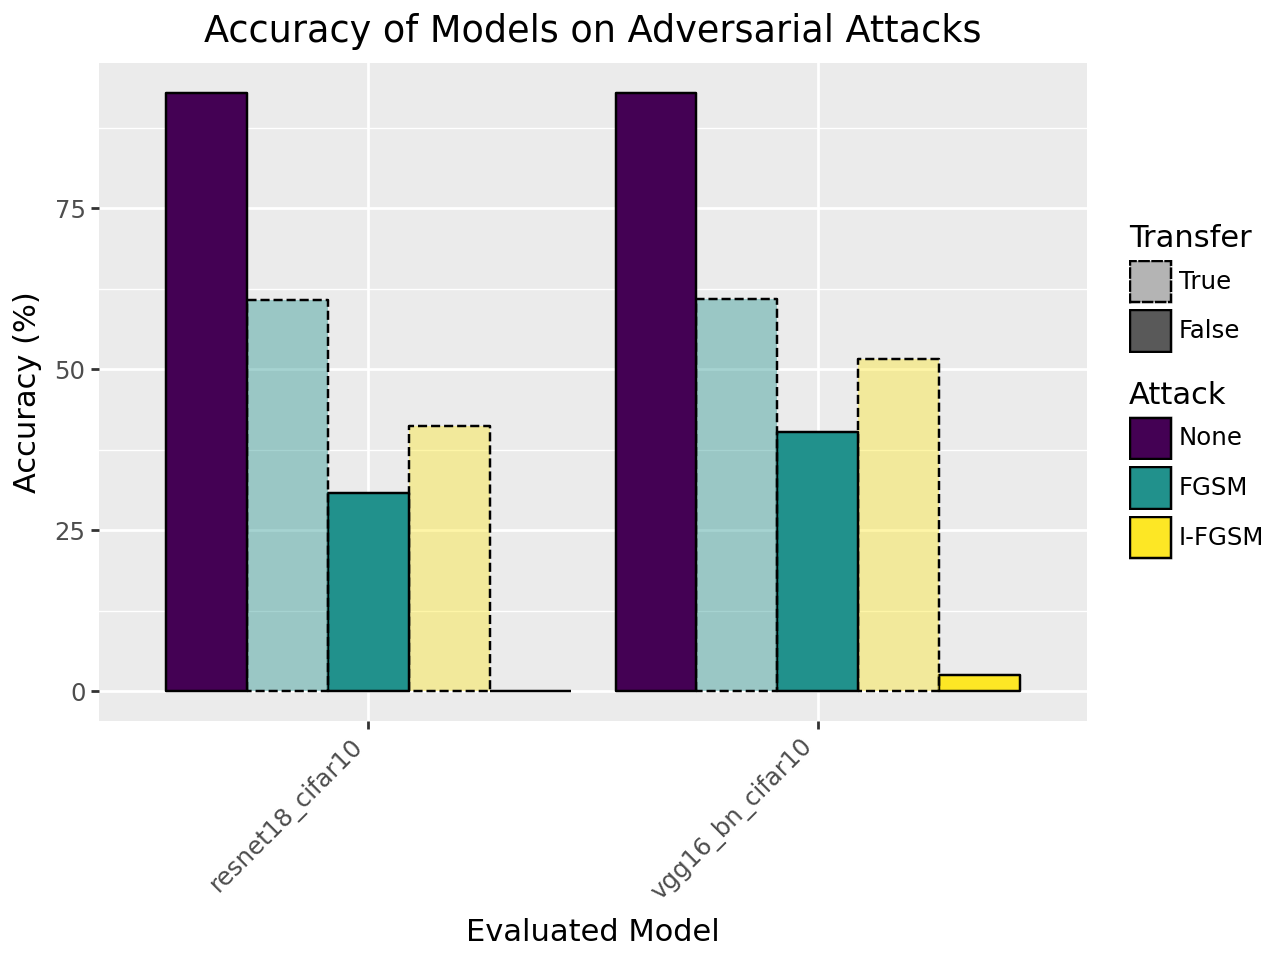

In [18]:
pd_result['attack_type'] = pd_result.apply(
    lambda row: f"{row['attack']} ({'transfer' if row['is_transferred'] else 'direct'})", axis=1
)

desired_attack_order = ['None', 'FGSM', 'I-FGSM']
pd_result['attack'] = pd.Categorical(pd_result['attack'], categories=desired_attack_order, ordered=True)
desired_is_transferred_order = [True, False]
pd_result['is_transferred'] = pd.Categorical(pd_result['is_transferred'], categories=desired_is_transferred_order, ordered=True)

plot = (
    pn.ggplot(pd_result)
    + pn.aes(
        x='evaluated_model',
        y='accuracy',
        fill='attack',
        alpha='is_transferred',
        linetype='is_transferred'  # Optional: linetype distinguishes transferred attacks
    )
    + pn.geom_bar(stat='identity', position='dodge', color='black')
    + pn.labs(
        title='Accuracy of Models on Adversarial Attacks',
        x='Evaluated Model',
        y='Accuracy (%)',
        fill='Attack',
        alpha='Transfer',
        linetype='Transfer'
    )
    + pn.scale_linetype_manual(values=['dashed', 'solid'])
    + pn.scale_alpha_manual(values={True: 0.4, False: 1.0})
    + pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1)
    )
)

plot.show()

### Sample images

Demonstrating attack for model: resnet18_cifar10

--- FGSM Attack Example ---


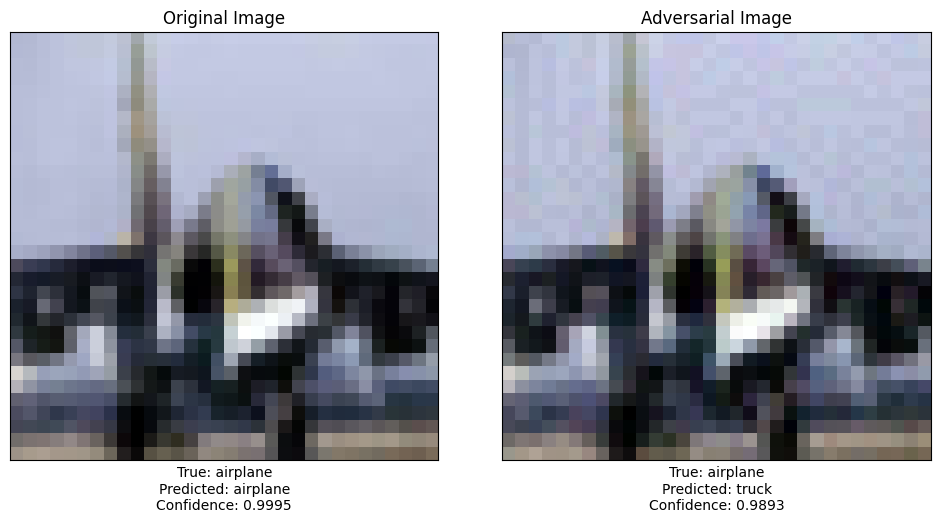


--- I-FGSM Attack Example ---


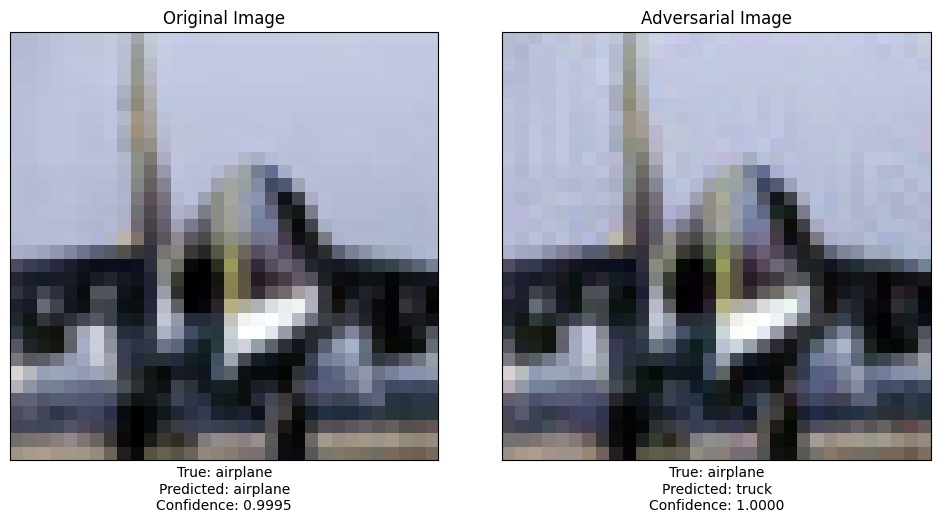

In [28]:
def predict_and_get_confidence(model, image, device=device):
  """
  Predict the class and get the confidence for a single image.

  Args:
      model (torch.nn.Module): The model to use for prediction.
      image (torch.Tensor): The input image tensor (normalized, shape (C, H, W)).
      device (torch.device): Device to run prediction on.

  Returns:
      tuple: (predicted_class_index, confidence)
  """
  model.to(device)
  image = image.unsqueeze(0).to(device) # Add batch dimension
  model.eval()
  with torch.no_grad():
    outputs = model(image)
    probabilities = torch.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probabilities, 1)

  return predicted.item(), confidence.item()

def display_attack_example(model, original_image, true_label, attack_function, dataset):
  """
  Displays original and adversarial images along with predictions and confidence.

  Args:
      model (torch.nn.Module): The model to use for prediction and attack.
      original_image (torch.Tensor): The original clean image (normalized, shape (C, H, W)).
      true_label (int): The true label of the image.
      attack_function (function): The adversarial attack function (e.g., FGSM_attack_lambda or I_FGSM_attack_lambda).
      dataset (torch.utils.data.Subset): The original dataset (used to get class names).
  """
  model.to(device)
  original_image = original_image.detach().to(device)
  true_label_tensor = torch.tensor([true_label]).to(device)

  # Generate adversarial image
  # We'll pass the original image with an added batch dimension.
  original_image_batch = original_image.unsqueeze(0)

  adversarial_image_batch = attack_function(model, original_image_batch, true_label_tensor)

  adversarial_image = adversarial_image_batch.squeeze(0).detach().cpu() # Remove batch dimension and move back to CPU

  # Get predictions and confidence for original and adversarial images
  original_pred, original_conf = predict_and_get_confidence(model, original_image.cpu())
  adversarial_pred, adversarial_conf = predict_and_get_confidence(model, adversarial_image)

  # Get class names from CIFAR-10 dataset
  class_names = dataset.dataset.classes # Access classes through Subset

  # Display images and information
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  # Original Image
  axes[0].imshow(prepare_image_for_imshow(original_image))
  axes[0].set_title("Original Image")
  axes[0].set_xlabel(f"True: {class_names[true_label]}\nPredicted: {class_names[original_pred]}\nConfidence: {original_conf:.4f}")

  # Adversarial Image
  axes[1].imshow(prepare_image_for_imshow(adversarial_image))
  axes[1].set_title("Adversarial Image")
  axes[1].set_xlabel(f"True: {class_names[true_label]}\nPredicted: {class_names[adversarial_pred]}\nConfidence: {adversarial_conf:.4f}")

  # remove axis ticks
  for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

  plt.tight_layout()
  plt.show()



# Select an example image from the balanced dataset
example_index = 5 # Choose an index
original_image, true_label = cifar10_dataset[example_index]

# Select a model to demonstrate the attack
example_model_config = models_list[0] # Using resnet18_cifar10 as the example model

print(f"Demonstrating attack for model: {example_model_config.name}")

# Demonstrate FGSM attack
print("\n--- FGSM Attack Example ---")
display_attack_example(
    model=example_model_config.model,
    original_image=original_image,
    true_label=true_label,
    attack_function=FGSM_attack_lambda,
    dataset=cifar10_dataset
)

# Demonstrate I-FGSM attack
print("\n--- I-FGSM Attack Example ---")
display_attack_example(
    model=example_model_config.model,
    original_image=original_image,
    true_label=true_label,
    attack_function=I_FGSM_attack_lambda,
    dataset=cifar10_dataset
)
